# Testing stock

* 時間, `最近成交價`, `當盤成交量`, `累積成交量`, `最佳五檔（賣價）`, `最佳五檔（賣量）`, `最佳五檔（買價）`, `最佳五檔（買量）`

In [1]:
import re
import numpy as np

def getDataset(path):
    dataset = []
    with open(path, 'r') as fp:
        for i in range(500):
            data = fp.readline()
            if len(data) == 0:
                break
            data = data.replace('-', '0')
            data = re.split(',|\n', data)[1:-1]
            data[3] = data[3].split('_')[0]
            data[4] = data[4].split('_')[0]
            data[5] = data[5].split('_')[0]
            data[6] = data[6].split('_')[0]
            try:
                dataset.append(np.asarray(data, dtype=np.float))
            except ValueError:
                print(data)
                
    return np.asarray(dataset)

# import tools

In [2]:
from tools import MinMaxScaler, stockEvn_single

# create dataset
* 1. price use MinMaxScaler with offset 0.1
* 2. trading volume using local MinMaxScaler
* 3. best 1 sell price use MinMaxScaler in 1.
* 4. best 1 buy price use MinMaxScaler in 1.
* 5. if sell count > buy count than > 0.5

In [3]:
choose = 500

def create_dataset(path, input_days=60, offset_choose=0.01):
    dataset = getDataset(path)
    price_sc = MinMaxScaler()
    price_sc.getScalerData(np.array([dataset[0][0]]), offset=0.1, feature_range=(0, 1))
    y_true = np.copy(dataset[:, 0])
    dataset[:, [0, 3, 5]] = price_sc.getTransformData(dataset[:, [0, 3, 5]])
    output = []
    label = []
    for i in range(input_days, choose):
        temp = dataset[i-input_days:i]
        # create total set
        temp_sc = MinMaxScaler()
        a = dataset[i-input_days:i, [0, 3, 5]]
        y = y_true[i]
        b = temp_sc.getScalerData(temp[:, 1:2])
        sell_count = temp[:, 4:5]
        buy_count = temp[:, 6:7]
        temp_scale = np.absolute(sell_count - buy_count) / np.maximum(sell_count, buy_count) / 2
        c = np.where(sell_count > buy_count, 0.5+temp_scale, 0.5-temp_scale)
        output.append(np.append(np.append(a, b, axis=-1), c, axis=-1))
        label.append(y)
    output = np.asarray(output, dtype=np.float)
    label = np.asarray(label, dtype=np.float)
    return output, label, price_sc.getParameter()

# Create model

In [4]:
RADAM = False
if RADAM:
    from keras_radam import RAdam
    from keras_lookahead import Lookahead
    optimizer = Lookahead(RAdam())
else:
    optimizer = 'adam'


input_days = 30
period = 1
epochs = 1
# batch_size = 1

In [5]:
# LSTM Training

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(CuDNNLSTM(units = 50, return_sequences = True, input_shape = (input_days, 5)))
model.add(CuDNNLSTM(units = 50, return_sequences = True))
model.add(CuDNNLSTM(units = 50, return_sequences = True))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 40, activation='relu'))
model.add(Dense(units = 3, activation='softmax'))
model.summary()
plot_model(model, 'model.png')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 30, 50)            11400     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 30, 50)            20400     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 30, 50)            20400     
_________________________________________________________________
flatten (Flatten)            (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               192128    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_________________________________________________________________
dens

# Define loss function

In [15]:
import tensorflow.keras.backend as K
import tensorflow as tf

def calculateLoss(y_true, y_pred):
    # create env
    env = stockEvn_single()
    # get MinMaxScaler
    sc = MinMaxScaler()
    sc.updatePatameter(sc_parameter)
    # change tensor to numpy
    y_pred_numpy = K.eval(y_pred)
    y_true_numpy = K.eval(y_true)
    # get y real
    y_real = sc.getInverseData(y_true_numpy)
    y_action = np.argmax(y_pred_numpy, axis=-1)
    loss = 0
    init_assets = env.getAssets()
    do_nothing_count = 0
    for i, action in enumerate(y_action):
        loss_t = env.doAction(y_real[i], action, 1.)
        if loss_t == 0:
            do_nothing_count += 1
#         loss_t = env.doAction(y_real[i], action, y_pred_numpy[i, action])
#         loss += loss_t
    final_assets = env.getAssets()
    reward = final_assets - init_assets
    if reward < 0:
        loss = -loss / (i+1)
    else:
        loss = 0.001
    loss += 0.0001 * do_nothing_count / (i+1)
    return loss
    
def envLoss(y_true, y_pred):
    loss = tf.py_function(calculateLoss, [y_true, y_pred], Tout=tf.float32)
    return loss

# Training the model

In [7]:
import os

dataset_path = "./dataset/Taiwan_5s/"
paths = np.load(dataset_path + 'paths_500.npy')

name = 'rl_01'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from functools import partial

sc_parameter = None
# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=period)
model.compile(optimizer = optimizer, loss = envLoss)
# training
train_history = []
for i in range(epochs):
    for i, path in enumerate(paths):
        if i > 1500:
            break
        x, y, sc_parameter = create_dataset(path=path, input_days=input_days)
        x[np.isnan(x)] = 0
        batch_size = x.shape[0]
        # train the model
        train = model.fit(x, y, epochs=1, batch_size=batch_size, callbacks=[], validation_split=0.0, shuffle=False)
        train_history.append(train.history['loss'])
        # save model
#         model.save('./model/' + name + '.h5')

470/470 [==============================] - 0s 32us/sample - loss: 0.0000e+00


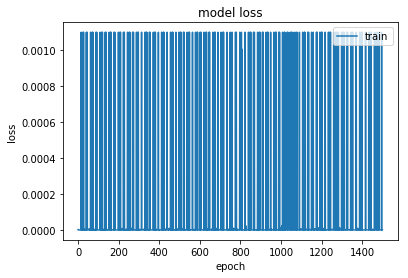

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [18]:
test_x, test_y, sc_parameter = create_dataset(path=paths[1844], input_days=input_days)
test_x[np.isnan(test_x)] = 0
pred = np.argmax(model.predict(test_x), axis=-1)
print(pred.shape, pred)

(470,) [2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


(470,)


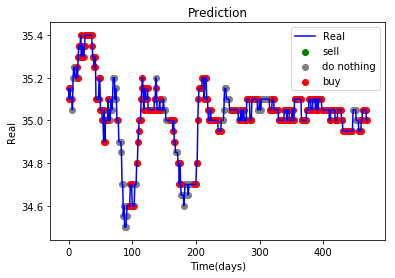

In [19]:
test_sc = MinMaxScaler()
test_sc.updatePatameter(sc_parameter)
test_real = test_x[:, -1, 0]
test_real = test_sc.getInverseData(test_real)
output_action = pred
print(test_real.shape)

# Visualising the results
plot = test_real
sell = np.where(output_action==0)
do_nothing = np.where(output_action==1)
buy = np.where(output_action==2)
plt.plot(plot, color = 'blue', label = 'Real')
plt.scatter(sell, plot[sell], color = 'green', label = 'sell')
plt.scatter(do_nothing, plot[do_nothing], color = 'gray', label = 'do nothing')
plt.scatter(buy, plot[buy], color = 'red', label = 'buy')
# plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()